In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [38]:
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.models import Sequential # 모델 객체 생성
from tensorflow.keras.utils import to_categorical # 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.layers import Input, Dense, Dropout # 모델 layer 쌓을 때 필요. 과적합시 필요
from tensorflow.keras.layers import LeakyReLU # leakyrelu는 activation='relu'처럼 leakyrelu 그대로 쓸 수 없고 %를 작성해줘야해서 import필요
from tensorflow.keras.metrics import Recall, Precision # accuracy 외에 정밀도, 재현율 설정
from tensorflow.keras.models import save_model, load_model # 모델 저장, 로드
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint # 로그출력 간소화, epoch다 돌아가기 전에 괜찮으면 끝내는것
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten # CNN

from sklearn.preprocessing import StandardScaler, MinMaxScaler # 정규화, 표준화
from sklearn.metrics import confusion_matrix # 혼동행렬, 교차표
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split # 데이터 분리

import matplotlib.pyplot as plt

In [3]:
# mnist 데이터 일부(30개)를 이미지 출력하기

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [4]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

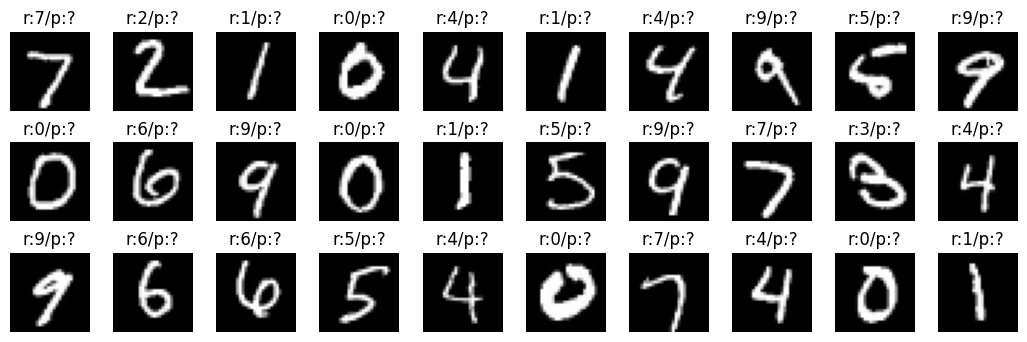

In [21]:
plt_row = 3
plt_col = 10

#plt.figure(figsize=(plt_col, plt_row)) 데이터가 많을때는 아래처럼 쓸수도 있음
plt.rcParams['figure.figsize'] = (plt_col*1.3, plt_row*1.3)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.4, wspace=0.3) # 서브플롯 위치조정

# 이렇게 하나하나 쓸 수 없으니 이 형식이 되게 for문을 돌릴것임
# axarr[0,0].imshow(X_test[0], cmap='gray')
# axarr[0,0].axis('off')
# axarr[0,0].set_title(f'real:{y_test[0]}')

for i in range(plt_row*plt_col):
    ax = axarr[i//plt_col, i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'r:{y_test[i]}/p:?')
    
# plt.tight_layout()
plt.show()

# 1. DNN

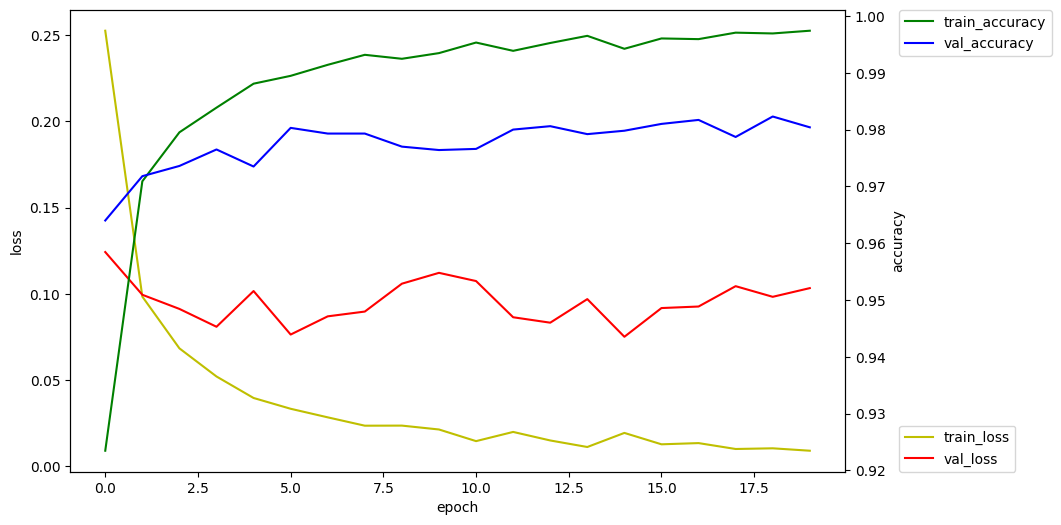

CPU times: total: 7min 2s
Wall time: 1min 20s


In [23]:
%%time

(X_train, y_train),(X_test, y_test) = mnist.load_data()

# Train데이터(6만개) → Train(5만개) + val(1만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

# X_train.reshape(50000, -1) 알아서 계산해줌
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 28*28).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0

# 분류분석을 위한 타겟변수의 원핫인코딩
train_Y = to_categorical(y_train, 10) # 10 : 카테고리수(안쓰면 자동계산)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

# 모델 생성
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(units=10, activation='softmax'))

# 학습과정 설정
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy 원핫 인코딩 안했을때 쓰는것. 자기가 원핫인코딩을 해줌
             optimizer= 'adam',
             metrics=['accuracy']) # 평가지표

#모델 학습
hist = model.fit(train_X, train_Y,
                epochs=20,
                batch_size=100,
                validation_data=(val_X,val_Y),
                verbose=0)

# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [24]:
# 모델 평가

loss, acc = model.evaluate(test_X, test_Y, verbose=0)
acc

0.9800999760627747

In [25]:
# 틀린 갯수

len(test_Y) - len(test_Y) * acc

199.00023937225342

In [29]:
# 틀린 이미지만 출력하기 위해, 실제값과 예측값을 추출

# 실제값
# real = np.argmax(test_Y, axis=1)
# real = test_Y.argmax(axis=1)
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [28]:
np.all(test_Y.argmax(axis=1) == np.argmax(test_Y, axis=1)) # == y_test


True

In [32]:
# 예측값

y_hat = model.predict(test_X).argmax(axis=1)
y_hat

313/313 [==============================] - 1s 3ms/step


array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [33]:
y_test.shape, y_hat.shape # 실제값과 예측값

((10000,), (10000,))

In [34]:
# 성능 평가표 (교차표, 혼동행렬)

pd.crosstab(y_test, y_hat, rownames=['real'], colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
real,,,,,,,,,,
0,973,1,0,0,1,0,2,1,2,0
1,0,1126,1,2,0,1,1,1,3,0
2,4,0,1003,9,2,0,1,8,5,0
3,0,0,0,997,0,3,0,4,3,3
4,1,1,5,1,959,0,2,0,0,13
5,3,0,0,7,1,873,4,2,0,2
6,4,2,0,0,6,4,941,0,1,0
7,1,1,6,1,0,0,0,1012,2,5
8,2,1,3,5,5,9,3,6,925,15


In [35]:
plt_row = 20
plt_col = 10

# 무조건 출력할게 아니라 틀린갯수 199개만 채우고 끝낼 예정
i = 0   # y_hat과 y_test를 액세스할 index : 0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1 ~ 200
while (cnt < plt_row*plt_col) & (i<len(y_test)): # cnt가 plt_row*plt_col보다 작을때까지는 일단 계속 출력해라. 그리고 i가 y_test전체 수보다 작을때까지.
    if(y_test[i]==y_hat[i]):
        i += 1
        continue # if문이 참이면 i값만 하나 증가시키고 다시 조건문으로 올라감. continue로 해서 else 필요없음
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    print(title, end='\t')
    i += 1
    cnt += 1

r:8/p:7	r:4/p:2	r:2/p:7	r:5/p:3	r:3/p:7	r:6/p:0	r:4/p:9	r:8/p:2	r:8/p:2	r:1/p:8	r:7/p:3	r:8/p:9	r:4/p:9	r:8/p:6	r:2/p:7	r:8/p:9	r:5/p:4	r:1/p:8	r:6/p:0	r:6/p:5	r:7/p:8	r:4/p:6	r:7/p:8	r:4/p:0	r:6/p:5	r:2/p:4	r:7/p:2	r:4/p:9	r:9/p:5	r:5/p:7	r:8/p:3	r:7/p:9	r:5/p:6	r:5/p:3	r:2/p:3	r:8/p:4	r:8/p:3	r:7/p:9	r:1/p:5	r:8/p:7	r:4/p:2	r:8/p:9	r:2/p:3	r:5/p:3	r:3/p:7	r:4/p:2	r:7/p:2	r:8/p:9	r:2/p:8	r:1/p:8	r:2/p:3	r:8/p:3	r:9/p:4	r:8/p:3	r:1/p:7	r:8/p:4	r:8/p:1	r:2/p:0	r:6/p:0	r:5/p:9	r:4/p:9	r:6/p:1	r:1/p:3	r:8/p:9	r:8/p:0	r:5/p:3	r:9/p:0	r:5/p:6	r:4/p:9	r:9/p:1	r:2/p:0	r:2/p:4	r:9/p:5	r:5/p:3	r:9/p:0	r:6/p:1	r:3/p:8	r:5/p:0	r:9/p:7	r:3/p:5	r:3/p:5	r:8/p:9	r:1/p:2	r:5/p:9	r:4/p:9	r:7/p:9	r:8/p:7	r:8/p:9	r:4/p:9	r:6/p:0	r:3/p:7	r:4/p:9	r:9/p:1	r:6/p:4	r:5/p:0	r:8/p:5	r:8/p:5	r:2/p:3	r:8/p:4	r:4/p:6	r:2/p:3	r:0/p:4	r:6/p:5	r:1/p:3	r:4/p:2	r:3/p:5	r:7/p:1	r:0/p:8	r:9/p:3	r:8/p:6	r:8/p:2	r:2/p:3	r:9/p:0	r:2/p:7	r:6/p:4	r:7/p:9	r:2/p:6	r:9/p:7	r:2/p:8	r:4/p:9	r:2/p:7	r:9/p:7	r:2/p:3	r:5/p:7	r:8/p:7	

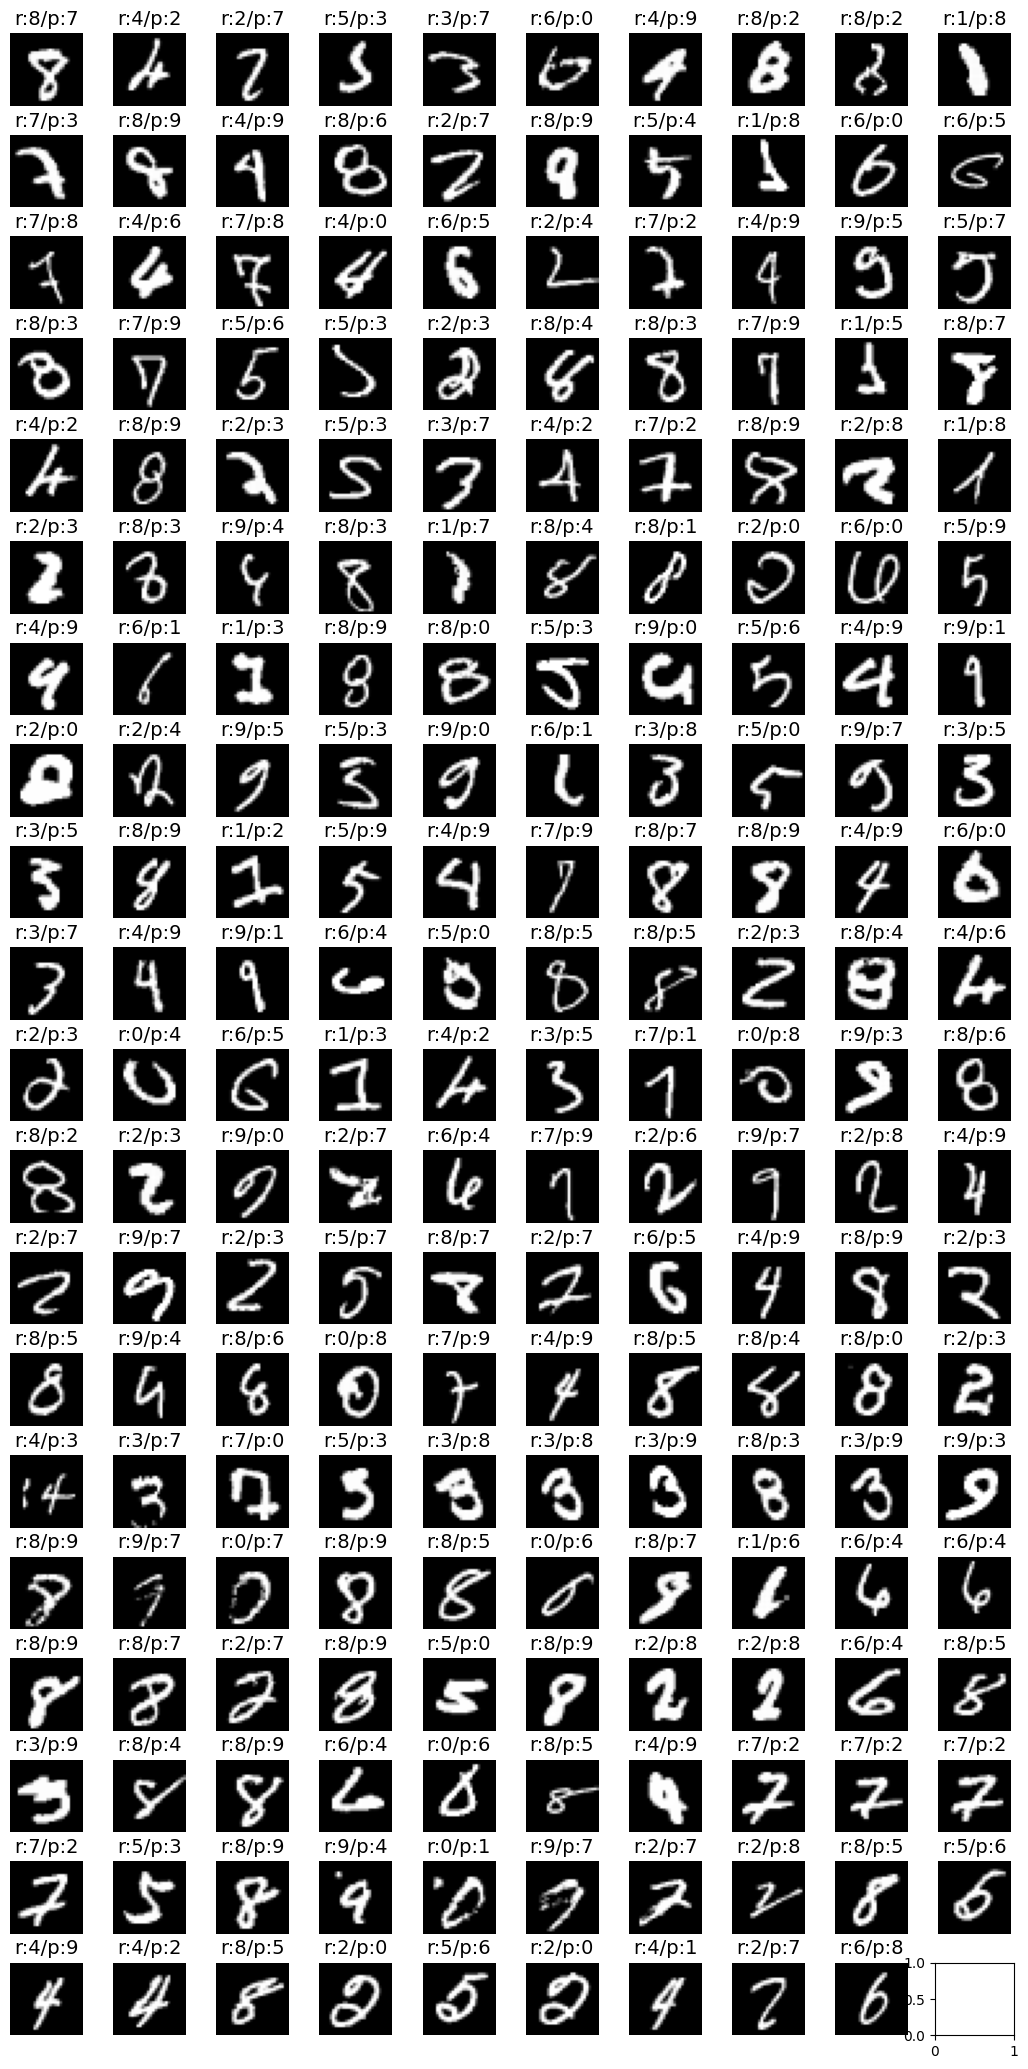

In [37]:
plt_row = 20
plt_col = 10

plt.rcParams['figure.figsize'] = (plt_col*1.3, plt_row*1.3)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.4, wspace=0.3) # 서브플롯 위치조정

i = 0   # y_hat과 y_test를 액세스할 index : 0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1 ~ 200
while (cnt < plt_row*plt_col) & (i<len(y_test)): 
    if(y_test[i]==y_hat[i]):
        i += 1
        continue 
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
    
# plt.tight_layout()
plt.show()

# 2. CNN

- 컨볼루션 layer → pooling →  컨볼루션 layer → pooling(2차원) → Flatten(1차원) →  DNN
- 컨볼루션과 pooling은 한세트

In [43]:
width = 28; heigt = 28
model = Sequential([Conv2D(filters=32,     # 필터수
                           kernel_size=3,  # 필터 사이즈 3x3
                           padding='same', # zero-padding / padding='valid'기본값
                           input_shape = (width, heigt, 1), # 숫자는 채널수. 1 : 흑백 / 3 : 컬러 / 4 : 투명도
                           activation='relu'),  # 28*28 1채널 이미지를 32개 필터로 특성맵 추출 → 28*28*31 특성맵
                    MaxPool2D(pool_size=(2,2)), # 가로2배, 세로2배 전체 4배로 줄어듦
                    Dropout(0.1),
                    Conv2D(filters=64,     
                           kernel_size=(3,3),  
                           activation='relu'),  
                    MaxPool2D(pool_size=(2,2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(units=128, activation='relu'),
                    Dropout(0.4),
                    Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 6, 6, 64)         

In [46]:
%%time

# 1. 데이터 생성 & 전처리
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# Train데이터(6만개) → Train(5만개) + val(1만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

# 스케일 조정은 해야함
train_X = X_train.astype('float32')/255.0
val_X = X_val.astype('float32')/255.0
test_X = X_test.astype('float32')/255.0

train_Y = to_categorical(y_train)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

# 2차원이어야함
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape

# 2. 모델 생성
width = 28; heigt = 28
model = Sequential([Conv2D(filters=32,     # 필터수
                           kernel_size=3,  # 필터 사이즈 3x3
                           padding='same', # zero-padding / padding='valid'기본값
                           input_shape = (width, heigt, 1), # 숫자는 채널수. 1 : 흑백 / 3 : 컬러 / 4 : 투명도
                           activation='relu'),  # 28*28 1채널 이미지를 32개 필터로 특성맵 추출 → 28*28*31 특성맵
                    MaxPool2D(pool_size=(2,2)), # 가로2배, 세로2배 전체 4배로 줄어듦
                    Dropout(0.1),
                    Conv2D(filters=64,     
                           kernel_size=(3,3),  
                           activation='relu'),  
                    MaxPool2D(pool_size=(2,2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(units=128, activation='relu'),
                    Dropout(0.4),
                    Dense(units=10, activation='softmax')
])

# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 학습하기
early_stopping = EarlyStopping(patience=10)
checkpoint = ModelCheckpoint(filepath='mnist-{epoch:02d}-loss{val_loss:.4f}-val{val_accuracy:.4f}.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

hist = model.fit(train_X, train_Y, epochs=50, batch_size=32, 
                 validation_data=(val_X, val_Y),
                 verbose=1,
                 callbacks=[early_stopping, checkpoint])

Epoch 1/50
1560/1563 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9334
Epoch 1: val_accuracy improved from -inf to 0.98430, saving model to mnist-01-loss0.0537-val0.9843.h5
1563/1563 [==============================] - 23s 14ms/step - loss: 0.2135 - accuracy: 0.9334 - val_loss: 0.0537 - val_accuracy: 0.9843
Epoch 2/50
1561/1563 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9763
Epoch 2: val_accuracy improved from 0.98430 to 0.98760, saving model to mnist-02-loss0.0401-val0.9876.h5
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0776 - accuracy: 0.9762 - val_loss: 0.0401 - val_accuracy: 0.9876
Epoch 3/50
1561/1563 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9815
Epoch 3: val_accuracy improved from 0.98760 to 0.99000, saving model to mnist-03-loss0.0361-val0.9900.h5
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0612 - accuracy: 0.9815 - val_loss: 0.0361 - val_accura

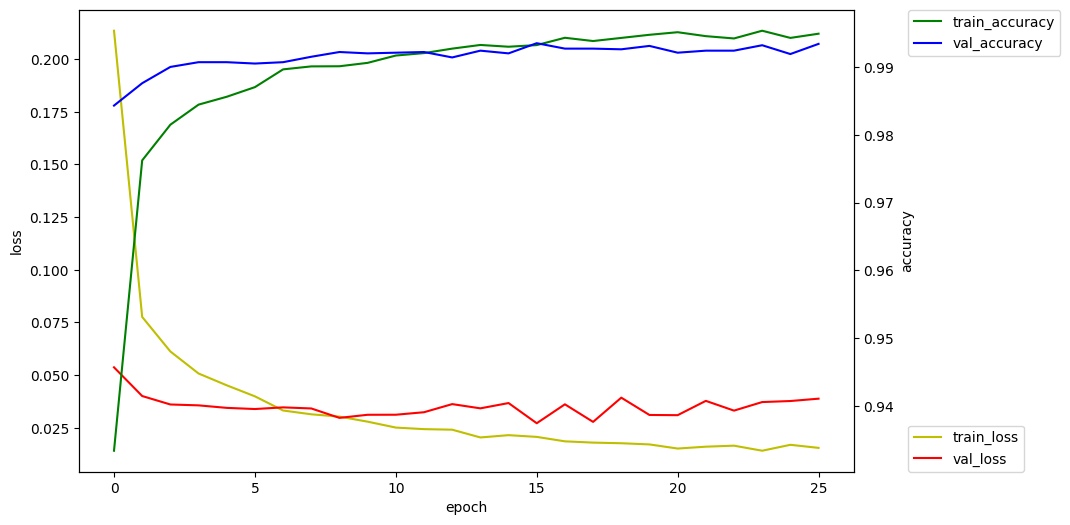

In [47]:
# 학습과정 표시하기

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [49]:
# 모델 평가

loss, acc = model.evaluate(test_X, test_Y, verbose=0)
print('최종모델 :', acc, loss)

최종모델 : 0.993399977684021 0.02889966405928135


In [52]:
model1 = load_model('mnist-14-loss0.0343-val0.9924.h5')
loss1, acc1 = model1.evaluate(test_X, test_Y, verbose=0)
print('model1 :', acc1, loss1)

model1 : 0.9934999942779541 0.024870002642273903


In [54]:
model2 = load_model('mnist-08-loss0.0342-val0.9915.h5')
loss2, acc2 = model2.evaluate(test_X, test_Y, verbose=0)
print('model1 :', acc2, loss2)

model1 : 0.9925000071525574 0.02667373977601528


In [62]:
# 성능 평가(성능평가지표 = 교차표,혼동행렬, acc, recall, precision, f1)를 위해 실제값, 예측값

# 실제값
y_test

# 예측값
y_hat = model1.predict(test_X, verbose=0).argmax(axis=1)

pd.crosstab(y_test, y_hat, rownames=['real'], colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
real,,,,,,,,,,
0,978,0,0,0,0,0,1,1,0,0
1,0,1133,0,1,0,0,0,1,0,0
2,1,1,1022,1,0,0,1,4,2,0
3,0,0,1,1008,0,1,0,0,0,0
4,0,0,0,0,972,0,0,0,2,8
5,1,0,0,8,0,881,1,0,0,1
6,2,3,0,0,1,1,951,0,0,0
7,0,2,1,0,0,0,0,1022,1,2
8,3,0,1,0,0,1,0,0,967,2


In [66]:
print('accuracy :', accuracy_score(y_test, y_hat))

# 다중분류 타겟변수의 균형이 비슷하면 'macro' / 균형이 안 잡힌 데이터면 'weighted'
print('recall :', recall_score(y_test, y_hat, average='weighted')) # 0,1 밖에 없을경우 실제값, 예측값만 쓰면 됨. 지금 우리는 0~9까지 있기 때문에 추가로써줘야함
print('precision :', precision_score(y_test, y_hat, average='weighted'))
print('f1 :', f1_score(y_test, y_hat, average='weighted'))

accuracy : 0.9935
recall : 0.9935
precision : 0.9935118366245294
f1 : 0.993499030445142


In [67]:
# 틀린갯수

len(y_test) - len(y_test)*acc1

65.00005722045898

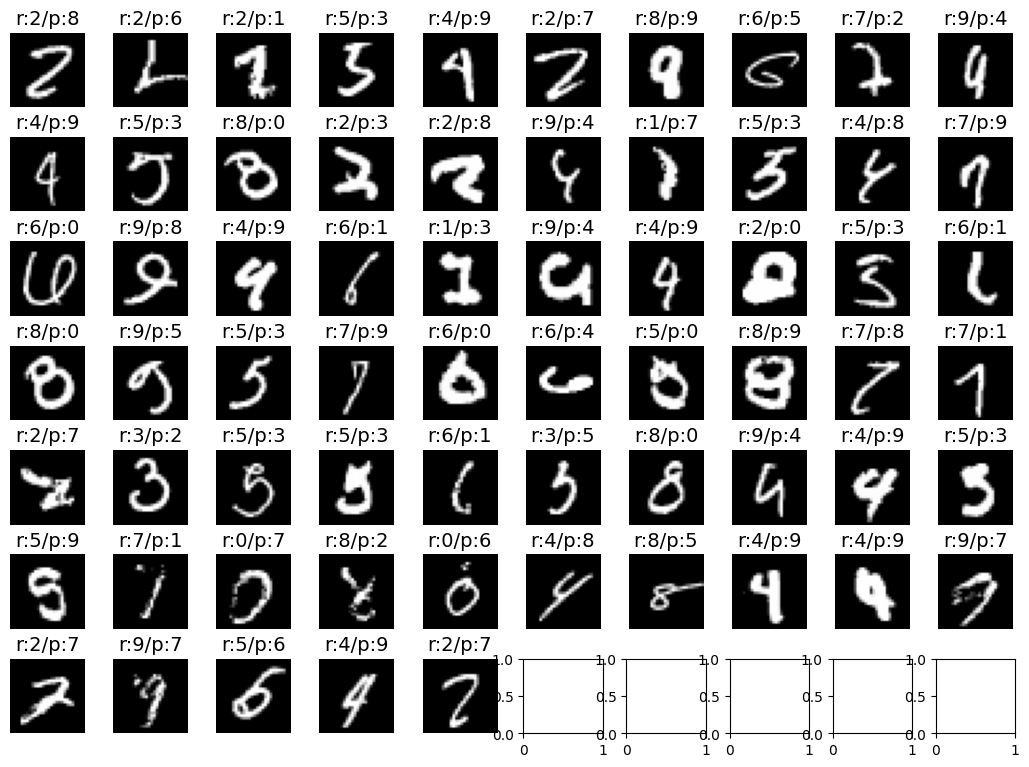

In [68]:
plt_row = 7
plt_col = 10

plt.rcParams['figure.figsize'] = (plt_col*1.3, plt_row*1.3)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.4, wspace=0.3) # 서브플롯 위치조정

i = 0   # y_hat과 y_test를 액세스할 index : 0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1 ~ 200
while (cnt < plt_row*plt_col) & (i<len(y_test)): 
    if(y_test[i]==y_hat[i]):
        i += 1
        continue 
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
    
# plt.tight_layout()
plt.show()